In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from sklearn import preprocessing
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
from scipy.stats import linregress
import textwrap

In [ ]:
import json
import os

class DataProcessor:
    def __init__(self, pathology_path, evidences_path):
        # Correctly handle the tilde in the file path
        pathology_path = os.path.expanduser(pathology_path)
        evidences_path = os.path.expanduser(evidences_path)

        # Initialize the dictionary
        self.pathology_dict = json.load(open(pathology_path, 'r'))
        self.evidences_dict = json.load(open(evidences_path, 'r'))

    def read_data(self, file_path):
        # read data
        return pd.read_csv(file_path)

    def check_typo(self, df):
        # check typos in evidences according to the dictionary
        for n, i in df.iterrows():
            if i['PATHOLOGY'] not in self.pathology_dict:
                print(f"{n} has a typo in pathology: {i['PATHOLOGY']}")
                df = df.drop(n)
            for evidence in i['EVIDENCES']:
                evidence_split = evidence.split('_@_')
                question = evidence_split[0]
                if question not in self.evidences_dict:
                    print(f'{n} has a typo in question: {evidence}')
                    df = df.drop(n)
                    continue
                if len(evidence_split) > 1:
                    value = evidence_split[1]
                    if value not in self.evidences_dict[question]["possible-values"] \
                        and value not in [str(e) for e in self.evidences_dict[question]["possible-values"]]:
                        print(f'{n} has a typo in value: {evidence}')
                        df = df.drop(n)
        return df

    def one_hot_encode(self, df):
        # convert the evidence into dummy variables
        unique_items = set(item for sublist in df['EVIDENCES'] for item in sublist)
        encoded_evidence = pd.DataFrame(0, index=df.index, columns=list(unique_items))
        for item in unique_items:
            encoded_evidence[item] = df['EVIDENCES'].apply(lambda x: item in x)
        return encoded_evidence.astype(int)

    def process_data(self, df):
        # process the data, drop duplicate and NA
        print("DataFrame shape: "+str(df.shape))
        print(df.isna().sum())
        df = df.dropna()
        print('Total Duplicate: '+str(df.duplicated().sum()))
        df = df.drop_duplicates()

        # split evidence
        evidences = []
        for evidence_row in df['EVIDENCES']:
            evidences.append([evidence.strip(" ''") for evidence in evidence_row.strip("[]").split(",") ])
        df['EVIDENCES'] = evidences


        # Drop possible outliers
        df = df[(df['AGE'] <= 120) & (df['AGE'] >= 0)]
        df = self.check_typo(df)
        df['SEX'] = df['SEX'].map({'M': 0, 'F': 1})
        encoded_df = self.one_hot_encode(df)
        df = df.drop('EVIDENCES', axis=1).join(encoded_df)
        print(df.head())

        return df


# Create an instance of the DataProcessor class
data_processor = DataProcessor('~/Desktop/capstone/data/release_conditions.json', '~/Desktop/capstone/data/release_evidences.json')

# Use the instance to call read_data
train = data_processor.read_data('~/Desktop/capstone/data/release_train_patients.csv')
validate = data_processor.read_data('~/Desktop/capstone/data/release_validate_patients.csv')
test = data_processor.read_data('~/Desktop/capstone/data/release_test_patients.csv')

# Process the data using the instance
train_processed = data_processor.process_data(train)
validate_processed = data_processor.process_data(validate)
test_processed = data_processor.process_data(test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Some evidences only exists in train/validate/test and not in others, so we have to union the columns
all_columns = pd.Series(list(train_processed.columns) + list(validate_processed.columns) + list(test_processed.columns)).drop_duplicates()
train = train_processed.reindex(columns=all_columns, fill_value=0)
validate = validate_processed.reindex(columns=all_columns, fill_value=0)
test = test_processed.reindex(columns=all_columns, fill_value=0)

# EDA

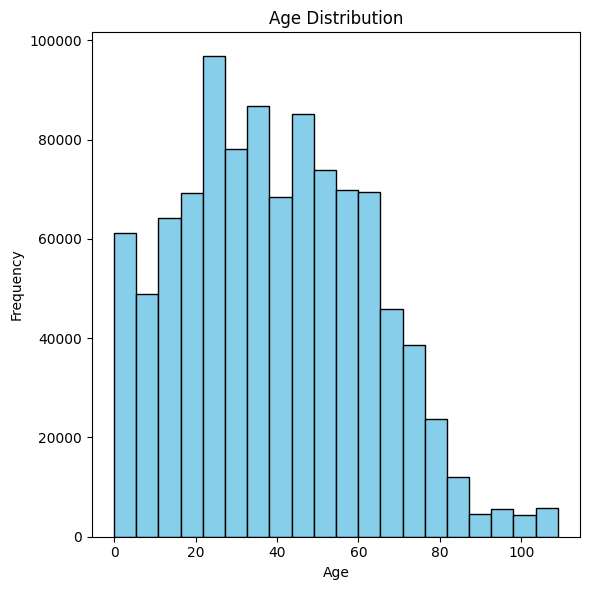

In [ ]:
import matplotlib.pyplot as plt

data = train['AGE']
plt.figure(figsize=(6, 6))
plt.hist(data, bins=20, edgecolor='black', color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
# plt.grid(True)
plt.tight_layout()
plt.show()


According to the barchart, the age distribution displayed within the dataset exhibits a close alignment with the demographic composition of the general population.

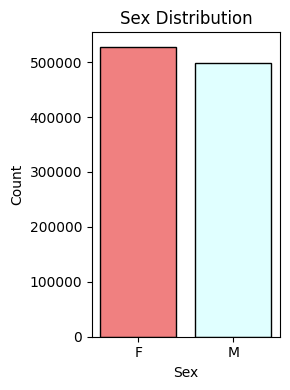

In [ ]:
import matplotlib.pyplot as plt
data2 = train2['SEX']
sex_counts = data2.value_counts()
plt.figure(figsize=(3, 4))
plt.bar(sex_counts.index, sex_counts.values, color=['lightcoral', 'lightcyan'], edgecolor='black')
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

According to the barcharts, there is a near-equivalent representation of male and female participants, with a marginal predominance of females.

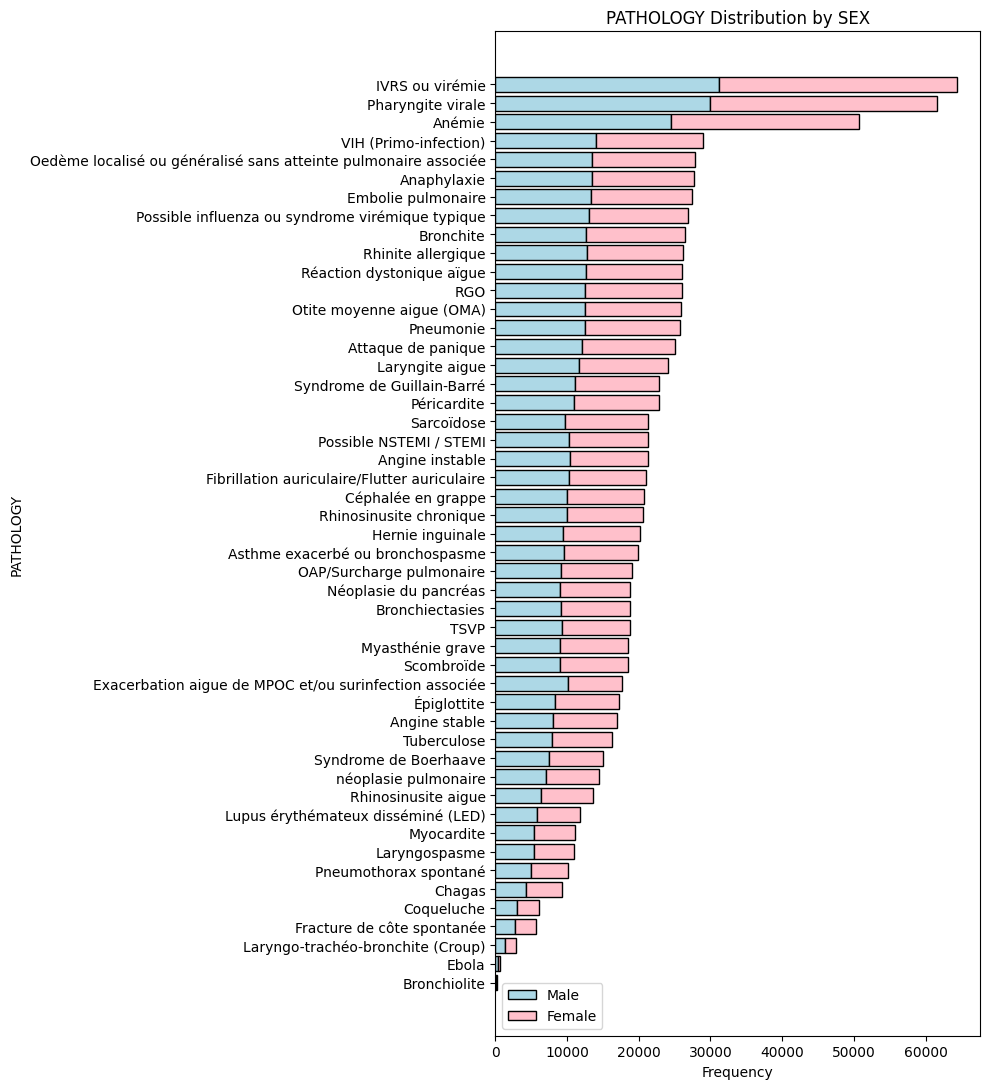

In [ ]:
grouped_data = train2.groupby(['PATHOLOGY', 'SEX']).size().unstack(fill_value=0)

grouped_data['Total'] = grouped_data.sum(axis=1)
grouped_data_sorted = grouped_data.sort_values(by='Total')


plt.figure(figsize=(10, 11))
for i, pathology in enumerate(grouped_data_sorted.index):
    males = grouped_data_sorted.loc[pathology, 0]
    females = grouped_data_sorted.loc[pathology, 1]
    plt.barh(pathology, males, edgecolor='black', color='lightblue')
    plt.barh(pathology, females, left=males, edgecolor='black', color='pink')

plt.title('PATHOLOGY Distribution by SEX')
plt.xlabel('Frequency')
plt.ylabel('PATHOLOGY')
plt.legend(['Male', 'Female'])
plt.tight_layout()
plt.show()


The horizontal barchart above is the distribution of pathologies and sex within our dataset. According to the chart, 'IVRS or viremia' is the most prevalent condition, followed by 'Viral Pharyngitis', 'Anemia', 'HIV (Primary Infection)', and 'Localized or Generalized Edema without Associated Pulmonary Involvement'. For most of the pathologies, the gender ratio is almost 1:1.

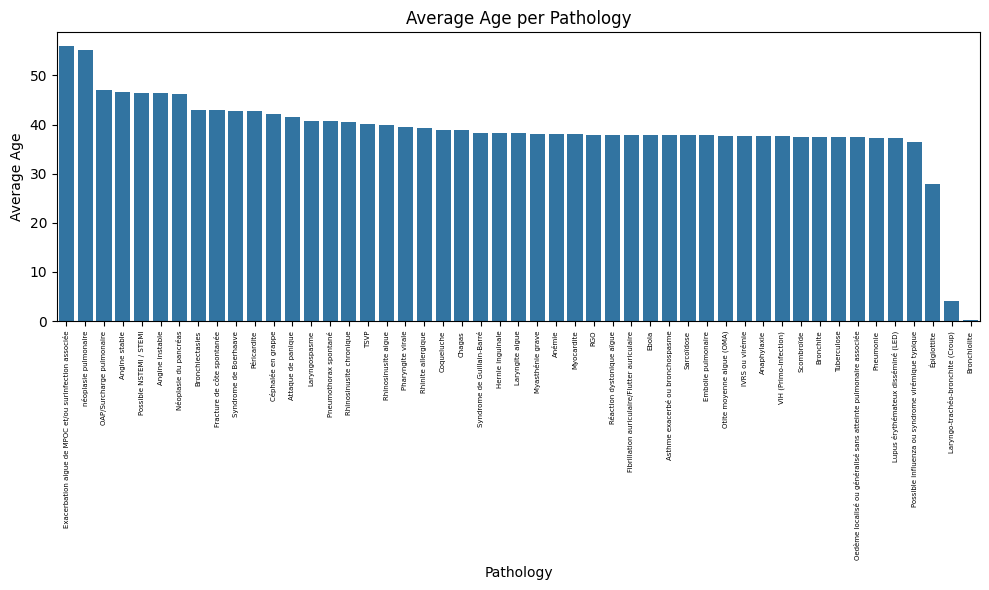

In [ ]:
train['AGE'] = train['AGE'].astype(float)
average_age = train.groupby('PATHOLOGY')['AGE'].mean().reset_index()

# sort the average age
average_age_sorted = average_age.sort_values('AGE', ascending=False)

# Visualize the data
plt.figure(figsize=(10, 6))
sns.barplot(data=average_age, x='PATHOLOGY', y='AGE', order=average_age_sorted['PATHOLOGY'])
plt.title('Average Age per Pathology')
plt.xticks(rotation=90, fontsize=5)
plt.xlabel('Pathology')
plt.ylabel('Average Age')
plt.tight_layout()
plt.show()

According to the barcharts, it is observed that 'Extraction dentaire' corresponds to the highest average age, whereas 'Bronchitis' is associated with the lowest.

In [ ]:
pathology_evidences = encoded_train.groupby(train['PATHOLOGY']).mean()

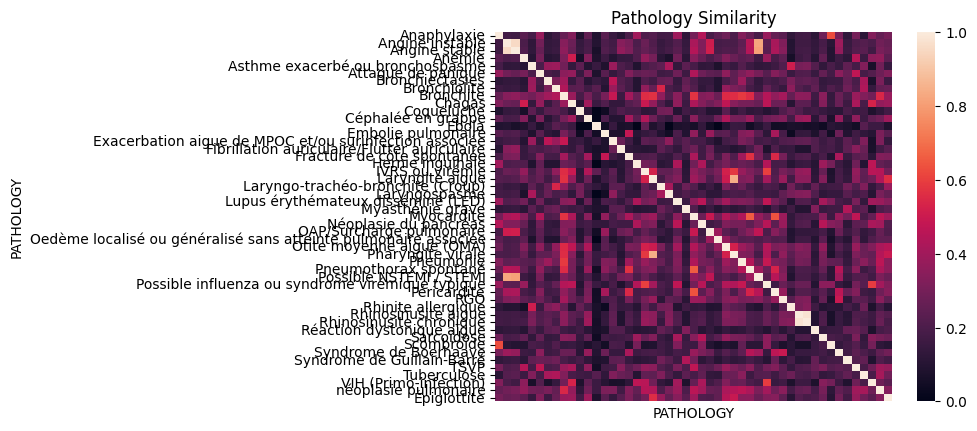

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = pd.DataFrame(cosine_similarity(pathology_evidences), index=pathology_evidences.index, columns=pathology_evidences.index)
sns.heatmap(similarity, xticklabels=False, yticklabels=True)
plt.title('Pathology Similarity')
plt.show()

In our research, we have developed a heatmap to visually represent the similarity between various pathologies, as determined by their respective evidences. This approach enables a quick understanding of the relationships and distinctions between different pathologies.

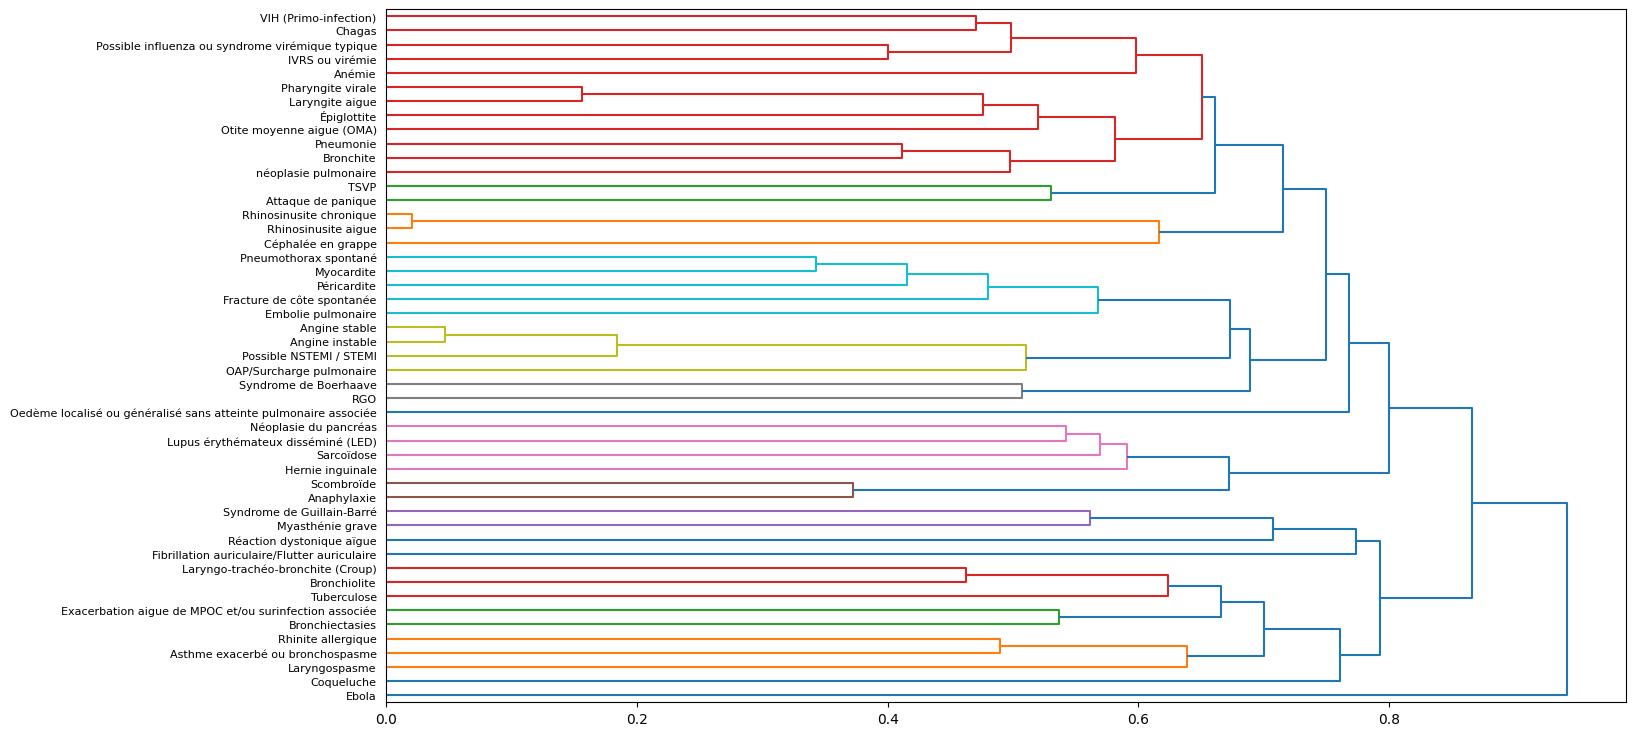

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["figure.dpi"] = 100
linkage_data = linkage(pathology_evidences, method='weighted', metric='cosine')
dendrogram(linkage_data, labels=pathology_evidences.index, orientation='right')
plt.show()

Since there are 49 pathologies, it’s hard to look through them one by one. Therefore, a dendrogram was constructed to provide a succinct visual representation of the similarities among pathologies based on their associated evidence. This approach allows for a rapid assessment of the inter-relationships between various disease states.